In [8]:
%matplotlib inline
import matplotlib


In [9]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import ndimage
import os
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import tensorflow.contrib.layers as layers
import tensorflow.contrib.slim as slim
from random import shuffle

In [10]:
total_azimuth_angles = 36
train_split = 0.8
image_H, image_W, image_D = 64,64,3

In [11]:
dataset = np.load('../datasets/car_64.npy')


1553596416


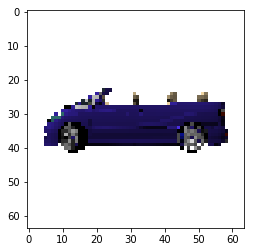

In [12]:
print(dataset.nbytes)
plt.imshow(dataset[711]/255)
plt.show()

In [13]:
 
total_models = dataset.shape[0] // total_azimuth_angles


train_models_len = int(total_models * train_split)
test_models_len = total_models - train_models_len

print(total_models,train_models_len,test_models_len)

3512 2809 703


In [14]:
dataset_train = dataset[:train_models_len*total_azimuth_angles]
dataset_test = dataset[train_models_len*total_azimuth_angles:]

print(dataset_test.shape)
print(dataset_train.shape)

(25308, 64, 64, 3)
(101124, 64, 64, 3)


In [15]:
del dataset
dataset_train.nbytes

1242611712

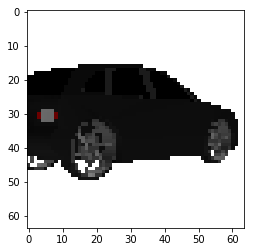

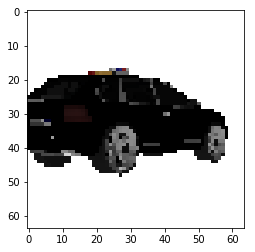

In [16]:
plt.imshow(dataset_train[1023]/255)
plt.show()
plt.imshow(dataset_test[1023]/255)
plt.show()

In [17]:
train_pairs = []
start_pose = [9]
for i in range(train_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                train_pairs.append((i,j,k))
                
test_pairs = []
start_pose = [9]
for i in range(test_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                test_pairs.append((i,j,k))


In [18]:
print(train_pairs[35])
print(test_pairs[35])
shuffle(train_pairs)
shuffle(test_pairs)
print(train_pairs[35])
print(test_pairs[35])

(1, 9, 0)
(1, 9, 0)
(2616, 9, 12)
(589, 9, 7)


(163, 9, 13)
(339, 9, 10)
98315


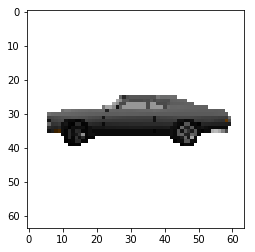

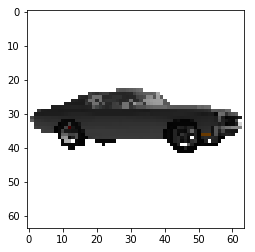

In [19]:
print(train_pairs[0])
print(test_pairs[0])

print(len(train_pairs))

i = dataset_train[(45*36) + 27]
j = dataset_train[(45*36) + 5]
plt.imshow(i/255)
plt.show()
plt.imshow(j/255)
plt.show()

In [20]:
def normalize(data):
    data *= 2.0
    data /= 255.0
    data -= 1.0
    return data

def denormalize(data):
    data = data + 1.0
    data = data * 255.0
    data = data / 2.0
    return data

In [21]:
c = 0
for p in train_pairs:
    if p[0] == 12 and p[1] == 0:
        c += 1
print(c)

0


In [22]:
#pairs (index_no, input, output)
def get_batch_data(pairs, train=True):
    l = train_models_len if train else test_models_len
    d = dataset_train if train else dataset_test
    i, ip, op = 0, 1, 2
    batch, batch_labels, pose = [], [], []
    for p in pairs:
        ip_index = (p[i] * total_azimuth_angles) + p[1]
        batch.append(d[ip_index])
        
        op_index = (p[i] * total_azimuth_angles) + p[2]
        batch_labels.append(d[op_index])
        
#         cur_pose =  np.zeros(36, dtype='uint8')
#         cur_pose[(p[2] - p[1]) % total_azimuth_angles] = 1
#         pose.append(np.broadcast_to(cur_pose,(8,8,36)))
        
    batch = np.array(batch, dtype=np.float64)
    batch_labels = np.array(batch_labels, dtype=np.float64)
#     pose = np.array(pose, dtype=np.float64)
    
    #normalize
    batch = normalize(batch)
    batch_labels =  normalize(batch_labels)
    
    return batch,batch_labels

batch, batch_labels = get_batch_data(train_pairs[36:72])

(36, 64, 64, 3) (36, 64, 64, 3)
<class 'numpy.float64'>
1.0 -0.98431372549


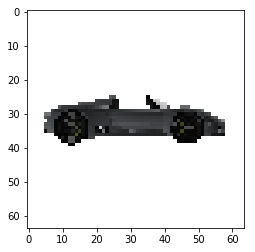

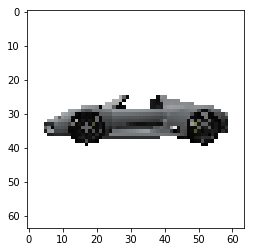

In [25]:
print(batch.shape, batch_labels.shape)

t = 27
# print(pose_labels[t][0][0])

print(type(batch_labels[t][0][0][0]))

print(np.max((batch[t])), np.min((batch[t])))

plt.imshow(denormalize(batch[t]) / 255)
plt.show()
plt.imshow(denormalize(batch_labels[t]) / 255)
plt.show()


In [26]:
tf.reset_default_graph()
#to Reset Tensor Flow Graph

In [27]:
#definition of my layers


# def conv2d(input, output, kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2d", act=None):
#     #act = tf.nn.leaky_relu
#     with tf.variable_scope(scope_name):
#         return layers.conv2d(inputs=input, num_outputs=output, kernel_size=[kernel_h, kernel_w], stride=k_stride, activation_fn=act,
#          biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02))

def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

def deconv2d(input, kernel_size, stride, num_filter):
    filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
    # tf.constant([input.get_shape()[0], input.get_shape()[1]*2, input.get_shape()[1]*2, num_filter], tf.int32)
    input_dim = input.get_shape().as_list()
    batch_size = input_dim[0]
    w = input_dim[1]
    out_shape = tf.stack([batch_size, w*2, w*2, num_filter])    

    stride_shape = [1, stride, stride, 1]
    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    
    return tf.nn.conv2d_transpose(input, W, out_shape, stride_shape)    
    
def loss_(inputs_, targets_):
    loss = tf.reduce_mean(abs(inputs_ - targets_))
    return loss


In [28]:


batch_size = 36
inputs_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")
targets_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="target")

In [30]:
# Building the encoder
#Layer Architecture
# Encoder will have Conv + relu + Conv + relu  + Conv + relu  
# After 3 Convolution ,we will have a latent space
#ae_reuse= False
def AutoEncoder(inputs_):
#        global ae_reuse

        
#        with tf.variable_scope('encoder', reuse=ae_reuse):
        with tf.variable_scope('conv1'):
            conv1 = conv2d(inputs_, 3, 2, 16)
            tanh1 = tf.nn.relu(conv1)
            #pool1 = max_pool(tanh1, 3, 2)

        # Size of pool1 would be 32*32*32

        with tf.variable_scope('conv2'):
            conv2 = conv2d(tanh1, 3, 2, 32)
            tanh2 = tf.nn.relu(conv2)
            #pool2 = max_pool(tanh2, 3, 2)

        # # Size of pool2 would be 16*16*16

        with tf.variable_scope('conv3'):
            conv3 = conv2d(tanh2, 3, 2, 64)
            tanh3 = tf.nn.relu(conv3)
            #pool3 = max_pool(tanh3, 3, 2)

        # # Latent space is 8*8*8
        # print pool3.get_shape().as_list()
        # #Building the decoder

        with tf.variable_scope('deconv1'):
            deconv1 = deconv2d(tanh3, 3, 2, 32)
            tanh4 = tf.nn.relu(deconv1)

        #print tanh4.get_shape().as_list()
        with tf.variable_scope('deconv2'):
            deconv2 = deconv2d(tanh4, 3, 2, 16)
            tanh5 = tf.nn.relu(deconv2)

        #print tanh5.get_shape().as_list()

        with tf.variable_scope('deconv3'):
            deconv3 = deconv2d(tanh5, 3, 2, 3)
            tanh6 = tf.nn.tanh(deconv3)

        #print tanh6.get_shape().as_list()
        return tanh6



In [31]:
global_step = tf.Variable(0,trainable=False)
learning_rate = 5e-4
decay_steps = 1000
decay_rate = 0.96

In [32]:
#calculate loss
tanh6 = AutoEncoder(inputs_)
loss_op = loss_(tanh6,targets_)

#Optimizer
# global_step = tf.Variable(0,trainable=False)
lr = tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(lr)
train_op = optimizer.minimize(loss=loss_op)

In [33]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 5
total_images = len(train_pairs)
step = 0

r = total_images // batch_size

for epoch in range(epochs):
    for ii in range(r):
        step += 1
        
        pairs = train_pairs[ii*batch_size : (ii+1)*batch_size]
        batch, batch_labels = get_batch_data(pairs)
        
        feed_dict = {inputs_: batch, targets_: batch_labels}
        _, loss = sess.run([train_op, loss_op], feed_dict = feed_dict)
        
        
        if step % 1000 == 0:
            print('Step {0}: loss = {1:.4f}'.format(step, loss))
            
    print('Epoch {0}: loss = {1:.4f}'.format(epoch, loss))

Step 1000: loss = 0.1890
Step 2000: loss = 0.1748
Epoch 0: loss = 0.1569
Step 3000: loss = 0.1864
Step 4000: loss = 0.2003
Step 5000: loss = 0.1518
Epoch 1: loss = 0.1548
Step 6000: loss = 0.1692
Step 7000: loss = 0.1689
Step 8000: loss = 0.1632
Epoch 2: loss = 0.1541
Step 9000: loss = 0.1967
Step 10000: loss = 0.1909
Epoch 3: loss = 0.1536
Step 11000: loss = 0.1687
Step 12000: loss = 0.1442
Step 13000: loss = 0.1714
Epoch 4: loss = 0.1531


In [34]:
t_pairs = test_pairs[3 * batch_size : 4 * batch_size]
test_batch, test_labels = get_batch_data(t_pairs, False)

In [35]:
feed_dict = { inputs_: test_batch}
op = sess.run([tanh6], feed_dict = feed_dict)

In [36]:
j = 20
op = denormalize(op[0])

In [37]:
print(np.min(op), np.max(op))

1.73688 255.0


In [38]:
op = np.where(op < 0.0,0.0, op)

In [39]:
print(np.min(op), np.max(op))

1.73688 255.0


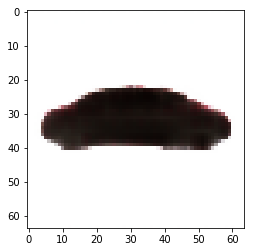

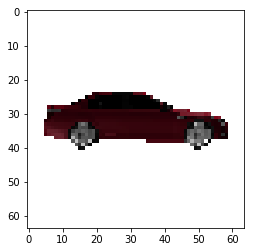

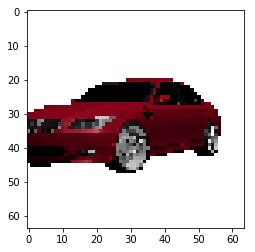

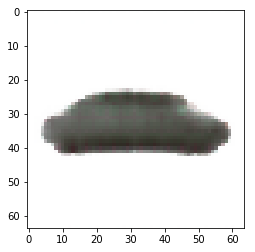

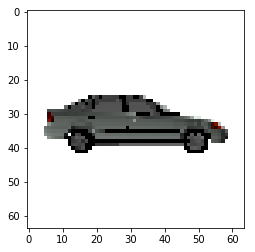

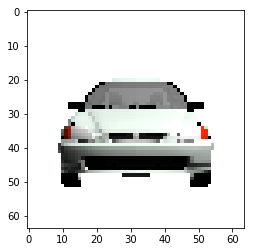

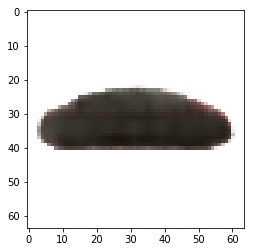

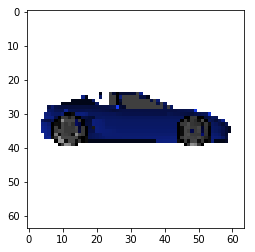

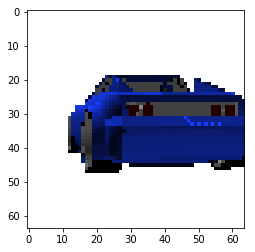

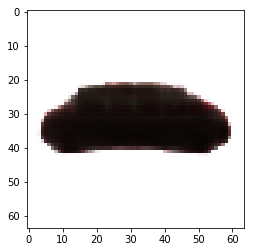

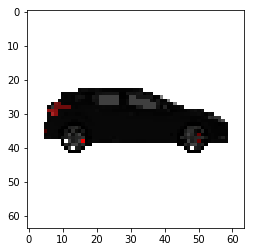

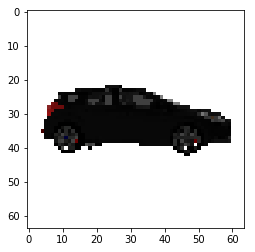

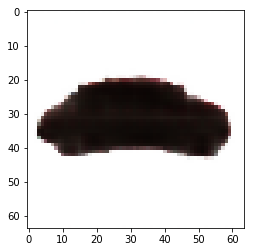

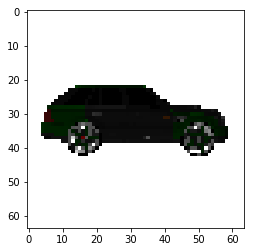

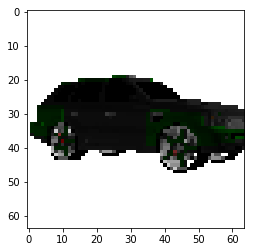

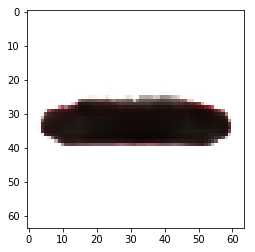

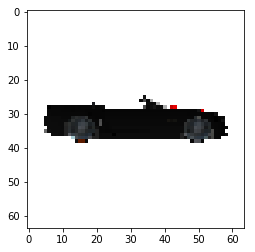

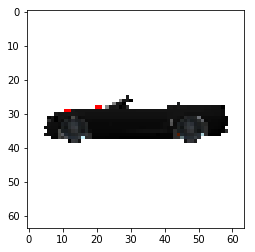

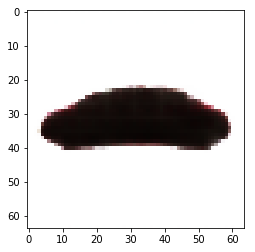

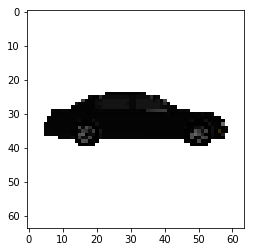

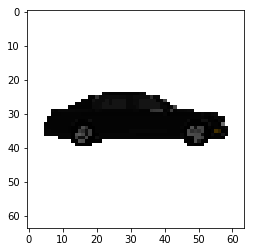

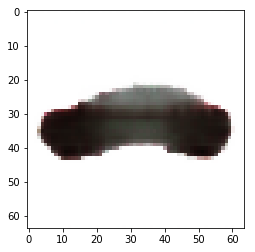

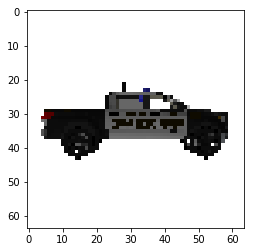

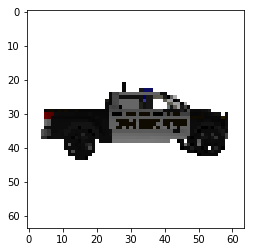

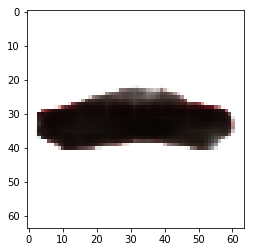

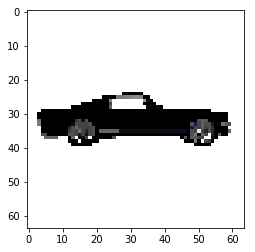

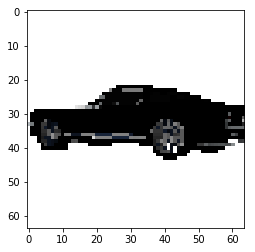

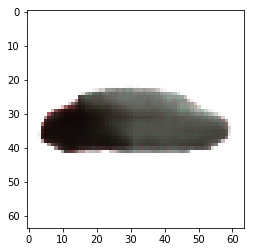

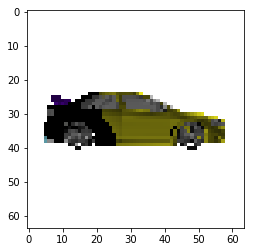

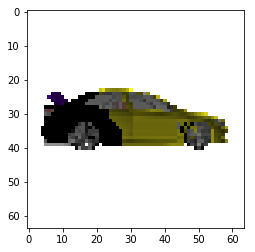

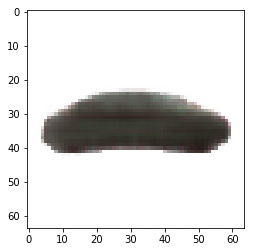

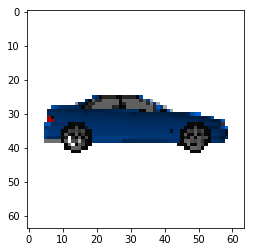

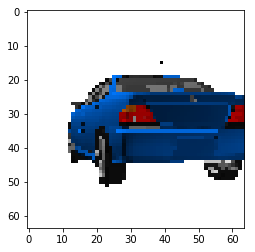

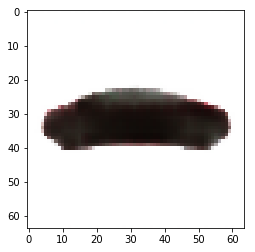

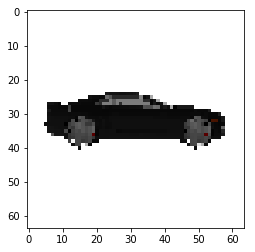

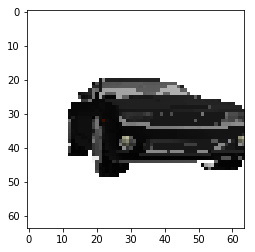

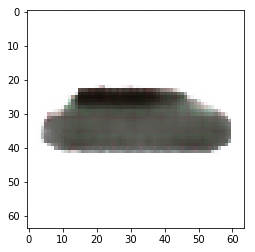

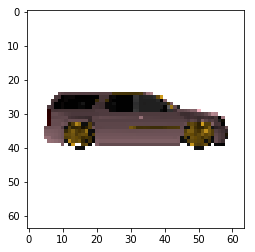

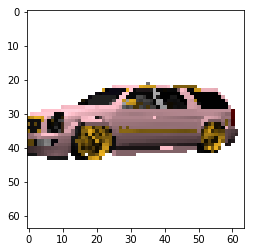

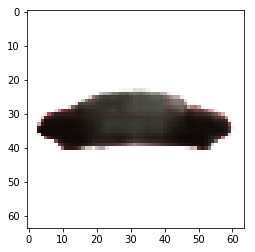

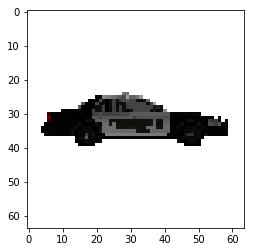

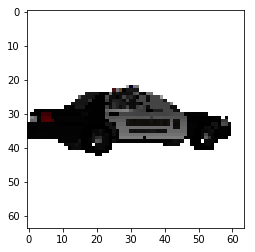

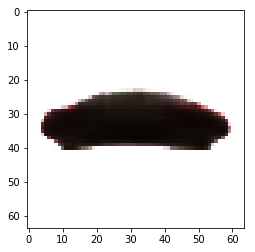

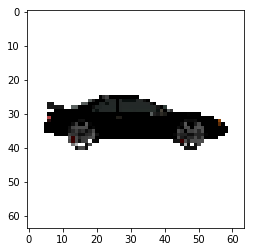

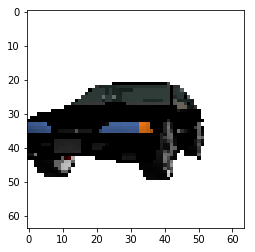

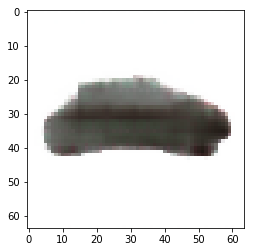

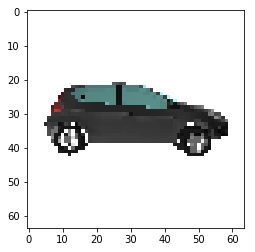

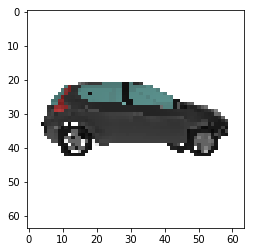

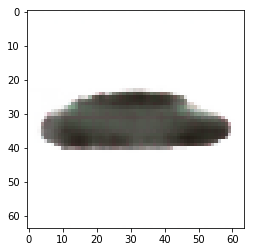

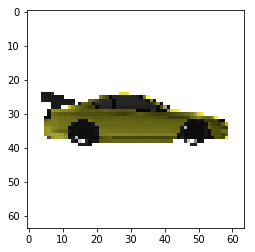

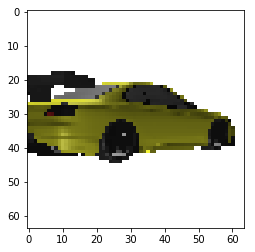

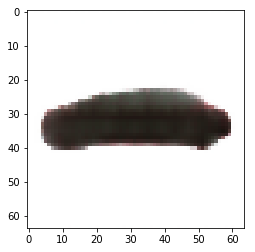

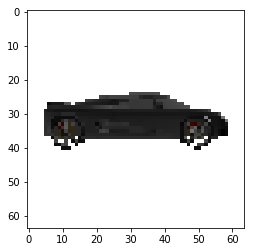

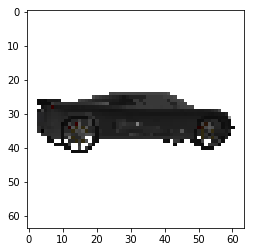

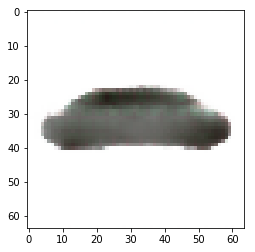

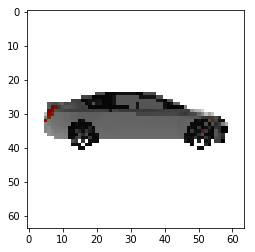

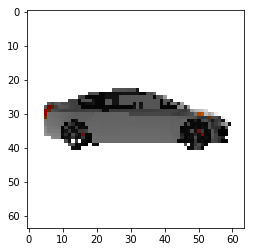

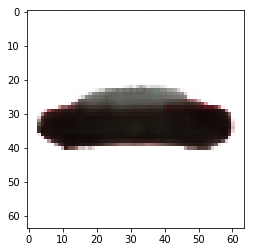

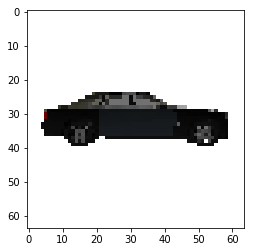

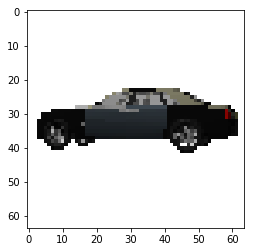

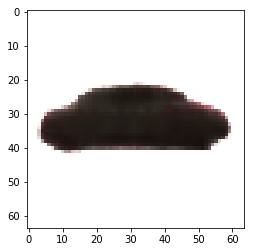

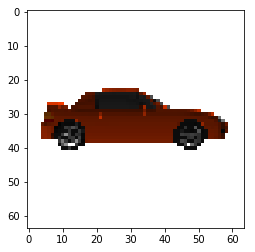

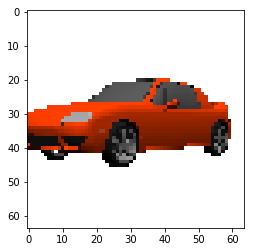

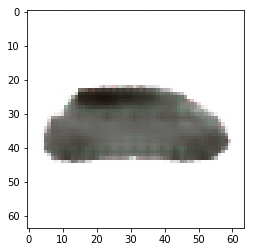

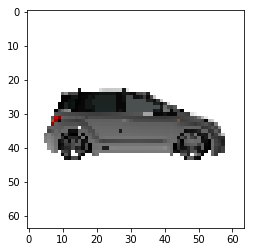

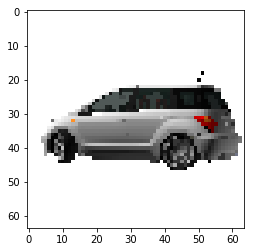

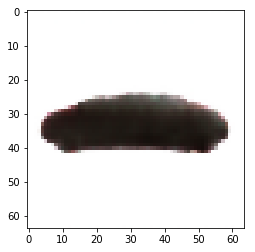

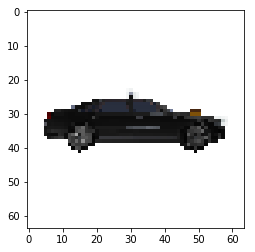

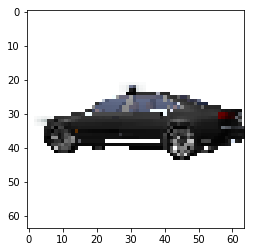

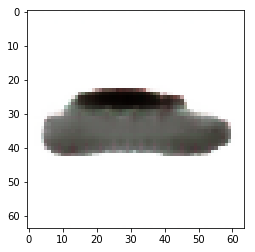

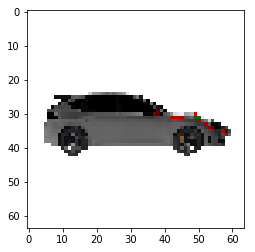

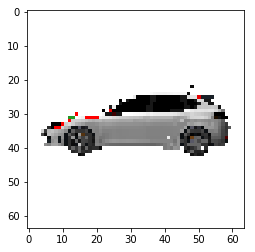

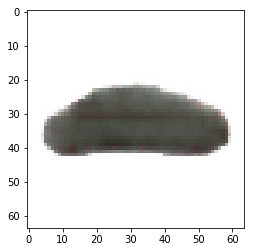

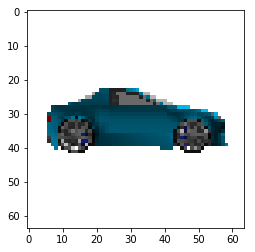

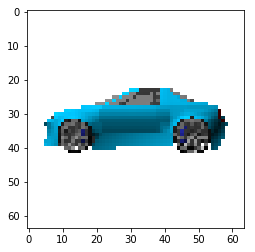

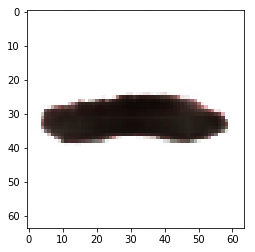

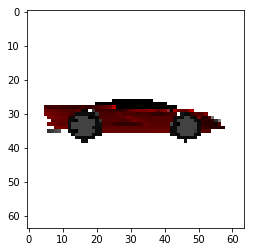

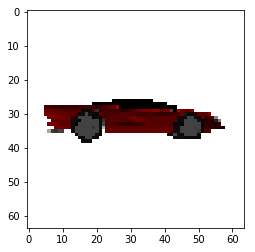

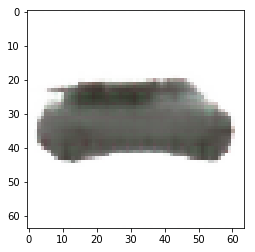

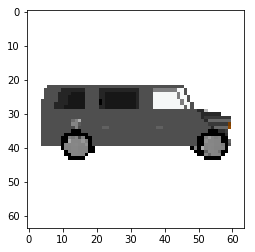

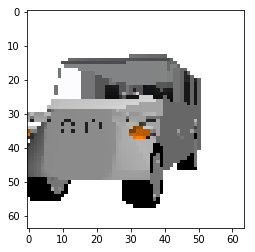

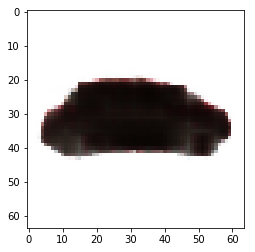

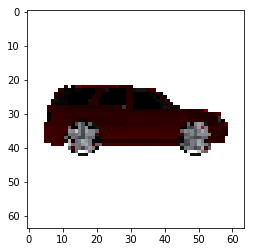

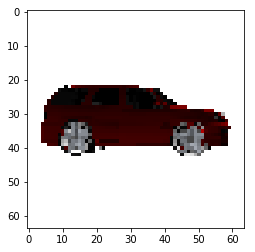

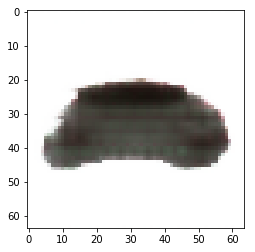

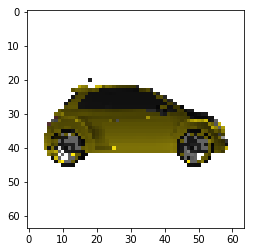

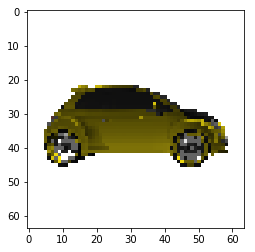

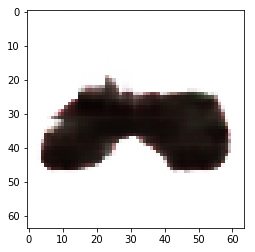

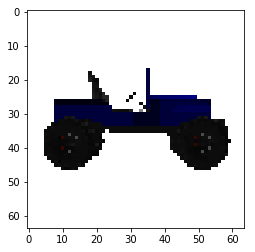

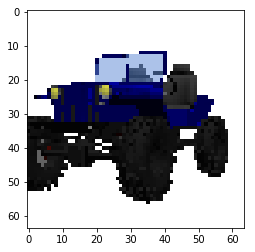

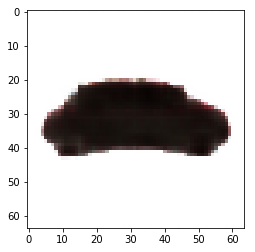

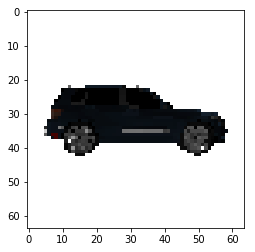

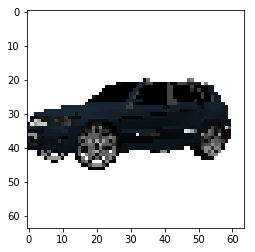

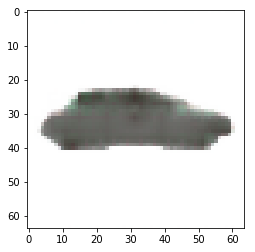

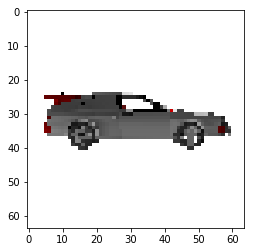

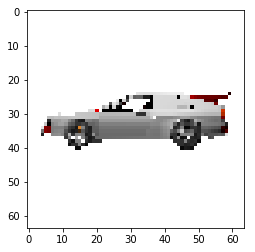

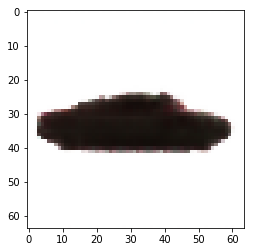

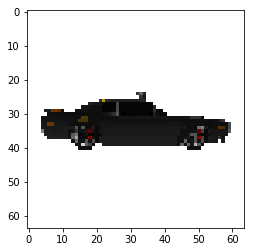

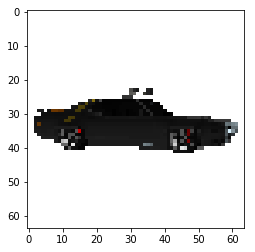

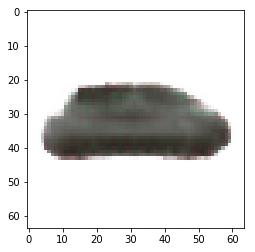

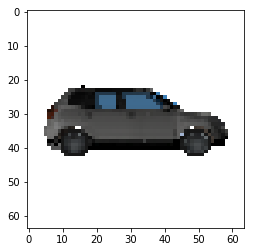

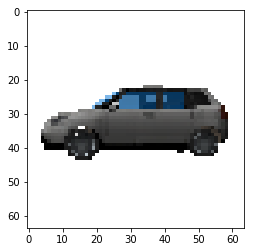

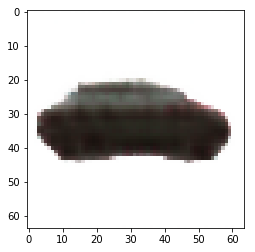

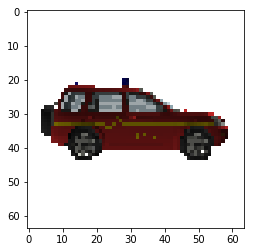

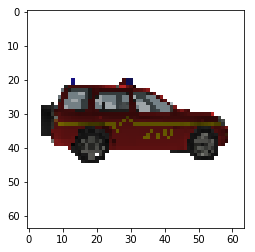

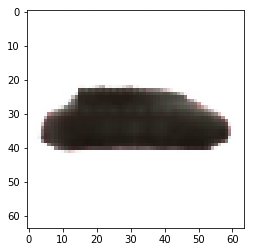

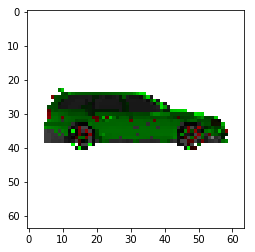

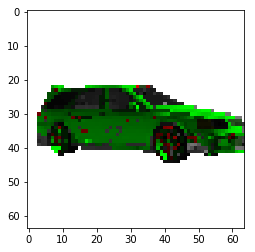

In [40]:
for j in range(batch_size):
    tmp = op[j]
    plt.imshow(tmp / 255)
    plt.show()

    plt.imshow(denormalize(test_batch[j])/255)
    plt.show()

    plt.imshow(denormalize(test_labels[j])/255)
    plt.show()